File that makes autoencoder

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline
from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [3]:
## Neccessary imports


# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../dat/data/'
annotation_csv = image_folder + 'annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

transform = torchvision.transforms.ToTensor()


In [5]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )



labeled_trainset = LabeledDataset(image_folder=image_folder,
annotation_file=annotation_csv,
scene_index=labeled_scene_index,
transform=transform,
extra_info=True
)


labeled_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=3, 
                                                  shuffle=True, num_workers=2, collate_fn=collate_fn)


unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, 
                                      first_dim='sample', transform=transform)
unlabeled_trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, 
                                                    shuffle=True, num_workers=2)

In [9]:

for sample in unlabeled_trainloader: #no camera index, weird. It is implied by channels, though. 
    break
    #if unlabeled, do not need (in fact it won't work) to stack. 
    sample_pred = model(sample)
    
    loss = F.mse_loss(sample_pred,sample)
    

In [200]:
for sample, target, road_image, extra in labeled_trainloader:
    
    #sample = torch.stack(sample) #probably good practice to straight up rename, preserves memory. 
    sample_pred, z = model(sample)
    loss = F.mse_loss(sample_pred,sample)
    break

In [ ]:
sample.std()

Sample is a batch size of 3, containing six images.

AUtoencoder separates this out, and we learn what we want to. 

In [18]:
#to get samples, 
sample[:,5].shape #0 to 5

torch.Size([3, 3, 256, 306])

# Now the autoencoder. 

In [192]:
def conv3x3(inplane, outplane, stride=1,padding=0):
    """
    Simple 3x3x3 convolutional block. Maybe I'll update it's name and break everything :-) 
    """
    return nn.Conv2d(inplane,outplane,kernel_size=3,stride=stride,padding=padding,bias=True)

class BasicBlock(nn.Module):
    """
    Basic convolutional block used for all non-dense blocks in my network. Specifically, this is the downsampling layer and bottleneck layers. 
    Since the bottleneck layer is better suited for dropout, I include the optional choice for either here, with a preset dropout val of 0.5.
    """
    def __init__(self,inplane,outplane,stride = 1,padding = 0, batchnorm=True,dropout=False):
        super(BasicBlock, self).__init__()
        self.padding = padding
        self.conv1 = conv3x3(inplane,outplane,padding=padding,stride=stride)
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.bn1 = nn.BatchNorm2d(outplane)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        if self.batchnorm:
            out = self.bn1(out)
        if self.dropout:
            out = self.dropout1(out)
        
        return out


class Custom_Autoencoder_Block(nn.Module):
    """
       Fairly custom-izable architecture for an autoencoder which accepts a sample image and combines at the bottleneck. 
    """
    
    def _make_layer(self,block,inplanes,outplanes,blocks,stride=1, padding=1,batchnorm=True,dropout=False): 
        #Make convolutional layer at each stage of U-Net.
        layers = []
        for i in range(0,blocks):
            layers.append(block(inplanes,outplanes,stride,padding,batchnorm,dropout))
            inplanes = outplanes  #how channelling is dealt with. Neat!
        return nn.Sequential(*layers)

    def __init__(self, block,in_ch,ch=32,nblocks = 2):
        super(Custom_Autoencoder_Block,self).__init__()
        #ENCODING
        self.layer1 = self._make_layer(block, in_ch, ch, blocks=nblocks,stride=1) #
        self.downsample1= self._make_layer(block,ch,2*ch, blocks=1,stride=2) #go down like this..
        self.layer2 = self._make_layer(block,2*ch,2*ch,blocks=nblocks,stride=1) #cat with deconv_batchnorm1
        self.downsample2 = self._make_layer(block,2*ch,2*2*ch,blocks=1,stride=2)
        self.layer3 = self._make_layer(block,2*2*ch,2*2*ch,blocks=nblocks,stride=1) #      
        self.downsample3 = self._make_layer(block,2*2*ch,2*2*2*ch,blocks=1,stride=2)
        self.upsample3 = nn.ConvTranspose2d(2*2*2*ch,2*2*ch,3,stride=2,padding=0,output_padding=0)
        self.deconv_batchnorm3 = nn.BatchNorm2d(num_features = 2*2*ch,momentum=0.1)
        self.layer4 = self._make_layer(block,2*2*ch,2*2*ch,blocks=nblocks,stride=1)
        self.upsample2 = nn.ConvTranspose2d(2*2*ch,2*ch,3,stride=2,padding=0,output_padding=0,)
        self.deconv_batchnorm2 = nn.BatchNorm2d(num_features = 2*ch,momentum=0.1) 
        self.layer5 = self._make_layer(block,2*ch,2*ch,blocks=nblocks,stride=1)
        self.upsample1 = nn.ConvTranspose2d(2*ch,ch,3,stride=2,padding=0,output_padding=1,)
        self.deconv_batchnorm1 = nn.BatchNorm2d(num_features = ch,momentum=0.1) 
        self.layer6 =  self._make_layer(block,ch,in_ch,blocks=nblocks,stride=1)
        
    def forward(self,x):
        
        x = self.layer1(x) #x1 is equal to the input after the first layer
        x  = self.downsample1(x) #x is the output of first layer fed into second layer
        x = self.layer2(x) #x2 is output of x fed into third layer
        x  = self.downsample2(x) #x is fourth layer's output from fed in x2
        x  = self.layer3(x) # output of layer 4 fed into layer 5
        z = self.downsample3(x) 
        x  = nn.functional.relu(self.deconv_batchnorm3(self.upsample3(z)),inplace=True)
        x = self.layer4(x)
        x = nn.functional.relu(self.deconv_batchnorm2(self.upsample2(x)),inplace=True)
        x = self.layer5(x)
        x =  nn.functional.relu(self.deconv_batchnorm1(self.upsample1(x)),inplace=True)
        x = self.layer6(x)
        x = F.pad(x,(-7,-7,-4,-4))
        return x,z
    
    
class Custom_Autoencoder_Full(nn.Module):
    """
       Joins 6 separate autoencoder blocks, to get the full context of the image. 
    """
    def __init__(self, block, auto_module ,in_ch,ch=32,nblocks = 2):
        super(Custom_Autoencoder_Full,self).__init__()

        self.module_a = auto_module(block,in_ch,ch,nblocks)
        self.module_b = auto_module(block,in_ch,ch,nblocks)
        self.module_c = auto_module(block,in_ch,ch,nblocks)
        self.module_d = auto_module(block,in_ch,ch,nblocks)
        self.module_e = auto_module(block,in_ch,ch,nblocks)
        self.module_f = auto_module(block,in_ch,ch,nblocks)

    def forward(self,x):
        xa = x[:,0]
        xb = x[:,1]
        xc = x[:,2]
        xd = x[:,3]
        xe = x[:,4]
        xf = x[:,5]
        
        xa, za = self.module_a(xa)
        xb, zb = self.module_b(xb)
        xc, zc = self.module_c(xc)
        xd, zd = self.module_d(xd)
        xe, ze = self.module_e(xe)
        xf, zf = self.module_f(xf)

        return torch.stack([xa,xb,xc,xd,xe,xf],dim=1), torch.stack([za,zb,zc,zd,ze,zf],dim=1)
    #reutn 

In [193]:
model = Custom_Autoencoder_Full(BasicBlock,Custom_Autoencoder_Block,in_ch=3)

In [194]:
x,z = model(sample)

In [199]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9161874

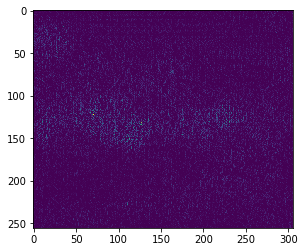

In [196]:
plt.imshow(x[0][0][0].detach())

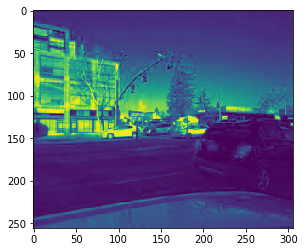

In [197]:
plt.imshow(sample[0][0][0])

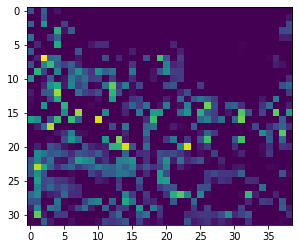

In [198]:
plt.imshow(z[0][0][0].detach())

In [2]:
def conv3x3x3(inplane, outplane, stride=1,padding=0):
    """
    Simple 3x3x3 convolutional block. Maybe I'll update it's name and break everything :-) 
    """
    return nn.Conv3d(inplane,outplane,kernel_size=3,stride=stride,padding=padding,bias=True)

class BasicBlock(nn.Module):
    """
    Basic convolutional block used for all non-dense blocks in my network. Specifically, this is the downsampling layer and bottleneck layers. 
    Since the bottleneck layer is better suited for dropout, I include the optional choice for either here, with a preset dropout val of 0.5.
    """
    def __init__(self,inplane,outplane,stride = 1,padding = 1, batchnorm=True,dropout=False):
        super(BasicBlock, self).__init__()
        self.padding = padding
        self.conv1 = conv3x3x3(inplane,outplane,padding=padding,stride=stride)
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.bn1 = nn.BatchNorm3d(outplane)
        self.dropout1 = nn.Dropout3d(p=0.5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        if self.batchnorm:
            out = self.bn1(out)
        if self.dropout:
            out = self.dropout1(out)
        
        return out



def crop_tensor(x):
    x = x.narrow(2,1,x.shape[2]-3).narrow(3,1,x.shape[3]-3).narrow(4,1,x.shape[4]-3).contiguous()
    return x

class CustomUNet(nn.Module):
    """
    Updated version of Siyu's U-Net designed for this task. Previously used in Jacky's paper too
    As an update, I have the two stages designed into one. 
    Either side is trainable in that regard. (This doesn't make sense when you say it aloud, but it will when you look at how this forward pass is called in the parallel training. )
    """
    

    
    def _make_layer(self,block,inplanes,outplanes,blocks,stride=1, padding=1,batchnorm=True,dropout=False): 
        #Make convolutional layer at each stage of U-Net.
        layers = []
        for i in range(0,blocks):
            layers.append(block(inplanes,outplanes,stride,padding,batchnorm,dropout))
            inplanes = outplanes  #how channelling is dealt with. Neat!
        return nn.Sequential(*layers)

    
    def __init__(self, block,in_ch,ch=32,nblocks = 2):
        super(CustomUNet,self).__init__()
                
        #ENCODING
        
        #layer 1, 64^3
        self.layer1 = self._make_layer(block, in_ch, ch, blocks=nblocks,stride=1) #
        
        #downsample 1, stride 2 kernel 3x3 padding 1
        self.downsample1 = self._make_layer(block,ch,2*ch, blocks=1,stride=2) #go down like this..
        
        #layer 2 ,32^3
        self.layer2 = self._make_layer(block,2*ch,2*ch,blocks=nblocks,stride=1) #cat with deconv_batchnorm1
    
        #downsample 2
        self.downsample2 = self._make_layer(block,2*ch,2*2*ch,blocks=1,stride=2)

        #layer 3, 16^3
        self.layer3 = self._make_layer(block,2*2*ch,2*2*ch,blocks=nblocks,stride=1) #      
        #downsample 3, last before bottleneck
        self.downsample3 = self._make_layer(block,2*2*ch,2*2*2*ch,blocks=1,stride=2)
        
        #BOTTLENECK         
        
        #bottleneck layer, 8^3.
        self.bottleneck = self._make_layer(block,2*2*2*ch,2*2*2*ch,blocks=nblocks,stride=1,batchnorm=False,dropout=True) 
        
        #size should be preserved after all of this... padding 1x1x1 and kernel 3x3x3
        
        #DECODING
        
        #upsample 3
        
        self.upsample3 = nn.ConvTranspose3d(2*2*2*ch,2*2*ch,3,stride=2,padding=0,output_padding=0)
        self.deconv_batchnorm3 = nn.BatchNorm3d(num_features = 2*2*ch,momentum=0.1)
        #this section gets paired with output of layer 3
        
        #layer 4, 16^3
        self.layer4 = self._make_layer(block,2*2*2*ch,2*2*ch,blocks=nblocks,stride=1)
        
        
        #upsample 2        
        self.upsample2 = nn.ConvTranspose3d(2*2*ch,2*ch,3,stride=2,padding=0,output_padding=0,)
    
        self.deconv_batchnorm2 = nn.BatchNorm3d(num_features = 2*ch,momentum=0.1) 
        #this section gets concatenated with output of layer 2 and 1.     
        #this channel number is weird since it contains skip connections from two different layers. 
        
        # layer 5, 32^3
        
        self.layer5 = self._make_layer(block, 4*ch ,ch,blocks=nblocks,stride=1)          

        self.classification_output_layer = nn.Conv3d(ch,2,1,stride=1,padding=0) # 1x1convolution, return 2 channels.
        
        self.regression_output_layer = nn.Conv3d(ch,1,1,stride=1,padding=0) # 1x1 convolution, return 1 channel. 
        



    def forward(self,x):
        #now the subhalo info isn't used at all! Let's see what happens.
        
        x1 = self.layer1(x) #x1 is equal to the input after the first layer
        x  = self.downsample1(x1) #x is the output of first layer fed into second layer
        
        
        x2 = self.layer2(x) #x2 is output of x fed into third layer
        x  = self.downsample2(x2) #x is fourth layer's output from fed in x2

        x3  = self.layer3(x) # output of layer 4 fed into layer 5
        x = self.downsample3(x3) #here it is! 

        x = self.bottleneck(x)
        x = F.pad(x,pad=(0,1,0,1,0,1),mode='constant',value = 0.)
        x  = nn.functional.relu(self.deconv_batchnorm3(crop_tensor(self.upsample3(x))),inplace=True)
        x  = torch.cat((x,x3),dim=1)  # combined layers, basically what U-Net is! 
        x  = self.layer4(x) #another set of convolutions to this cropped tensor
        x = F.pad(x,pad=(0,1,0,1,0,1),mode='constant',value = 0.)
        x  = nn.functional.relu(self.deconv_batchnorm2(crop_tensor(self.upsample2(x))),inplace=True)
        x  = torch.cat((x,x2),dim=1)
        x = self.layer5(x)        
        x_p1 = self.classification_output_layer(x)  #phase 1, classification
        x_p2 = self.regression_output_layer(x) # phase 2, regression. 
        
        return F.softmax(x_p1,dim=1), nn.functional.threshold(x_p2, -0.016379319, -0.016379319) 
        